<a href="https://colab.research.google.com/github/javanmesh/MyWebsite/blob/main/BungomaCardiacCare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Installing Libraries

In [1]:
# Install missing libraries
!pip install geopandas contextily pulp seaborn plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 20.1 MB/s eta 0:00:00


2. Importing Libraries

In [2]:
# Core Libraries
import pandas as pd
import numpy as np
import os

# Geospatial Libraries
import geopandas as gpd
from shapely.geometry import Point, box
import contextily as ctx

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.lines as mlines
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

import matplotlib.colors as mcolors

# Optimization
import pulp

# Configuration
plt.rcParams.update({'font.family': 'sans-serif'})

3. Setting Directories and File Paths

In [3]:
# Mount Google Drive (if in Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define Base Directories
base_dir = "/content/drive/MyDrive/healthcareBungoma"
data_dir = os.path.join(base_dir, "data")
results_dir = os.path.join(base_dir, "results")
os.makedirs(results_dir, exist_ok=True)

# File Paths
csv_path = os.path.join(data_dir, "bungoma_population.csv")
shp_path = os.path.join(data_dir, "bungoma_boundary.shp")
hospitals_csv = os.path.join(data_dir, "existing_facilities_level5.csv")
isochrones_path = os.path.join(data_dir, "isochrones.shp")
roads_path = os.path.join(data_dir, "roads.shp")
candidate_sites_shp = os.path.join(base_dir, "candidate_sites.shp")
pop_points_shp = os.path.join(base_dir, "population_points.shp")

Mounted at /content/drive


4. Loading data

In [4]:
# Population Data
df = pd.read_csv(csv_path)

# Boundary Shapefile
boundary = gpd.read_file(shp_path).to_crs("EPSG:4326")

# Hospitals Data
hospitals = pd.read_csv(hospitals_csv)
gdf_hospitals = gpd.GeoDataFrame(
    hospitals,
    geometry=gpd.points_from_xy(hospitals.longitude, hospitals.latitude),
    crs="EPSG:4326"
)

# Isochrones
isochrones = gpd.read_file(isochrones_path).to_crs("EPSG:4326")

# Roads Data
roads = gpd.read_file(roads_path).to_crs("EPSG:4326")

5. Data preprocessing

In [5]:
# Merge and Clip Isochrones
isochrones_merged = isochrones.dissolve()
isochrones_clipped = gpd.clip(isochrones_merged, boundary)

# Create 1km Grid (for Candidate Sites)
minx, miny, maxx, maxy = boundary.total_bounds
grid_size = 0.01  # ~1km in degrees
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in np.arange(minx, maxx, grid_size) for y in np.arange(miny, maxy, grid_size)]
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs="EPSG:4326")
grid = gpd.overlay(grid, boundary, how="intersection")


# Fix 1: Dissolve overlapping isochrones into a single feature
# This combines all isochrone polygons into one, removing overlaps
dissolved_isochrones = isochrones.geometry.union_all()
dissolved_isochrones_gdf = gpd.GeoDataFrame(geometry=[dissolved_isochrones], crs=isochrones.crs)

# Fix 2: Clip the isochrones to the Bungoma boundary
# This ensures isochrones don't extend beyond the county boundary
clipped_isochrones = gpd.clip(dissolved_isochrones_gdf, boundary)


# Filter Population Points Outside Isochrones
population_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)

total_population = df['population'].sum()

# Find population points that intersect with the clipped isochrones
# This will give us the points *inside* the isochrones
pop_covered = gpd.sjoin(population_gdf, isochrones_clipped, how="inner", predicate="intersects")

# Get the indices of the population points that are covered
covered_indices = pop_covered.index

# Select the population points that are *not* in the covered indices
# This gives us the points *outside* the isochrones
pop_uncovered = population_gdf[~population_gdf.index.isin(covered_indices)]

6. Population Density & Existing Hospitals

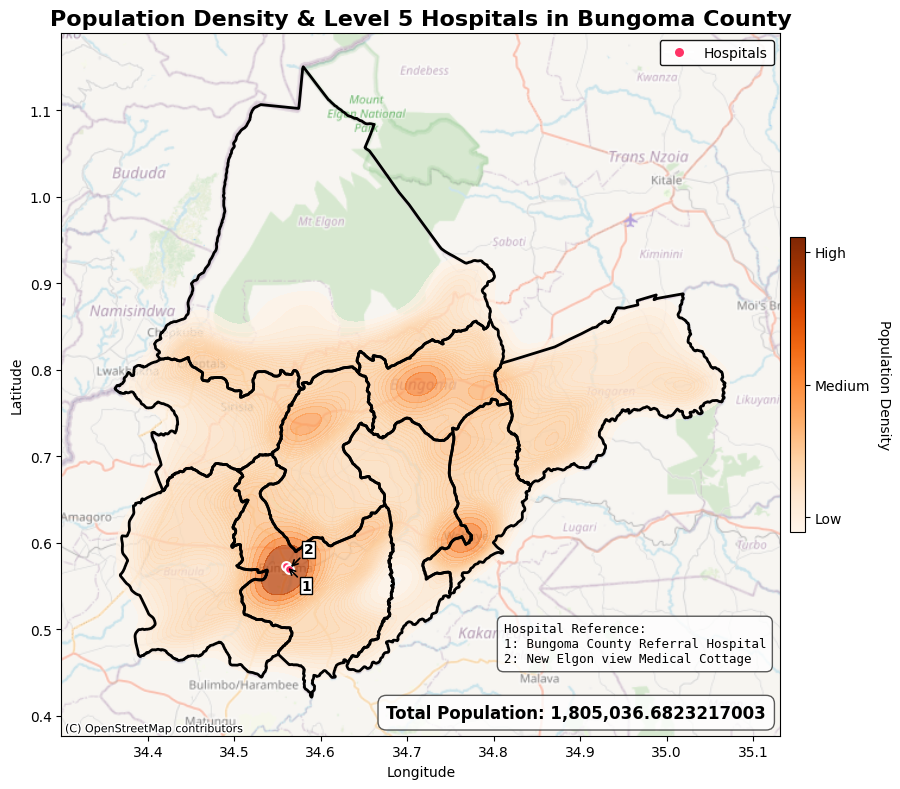

In [6]:

# Custom orange colormap
orange_colors = ["#fff5eb","#fee6ce","#fdd0a2","#fdae6b","#fd8d3c",
                 "#f16913","#d94801","#a63603","#7f2704"]
custom_cmap = LinearSegmentedColormap.from_list("oranges", orange_colors)

# Create plot
fig, ax = plt.subplots(figsize=(10,8))

# Plot boundary
boundary.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2, zorder=3)

# Population density KDE
sns.kdeplot(
    x=df.longitude, y=df.latitude,
    weights=df.population,
    cmap=custom_cmap, fill=True,
    alpha=0.7, levels=30, thresh=0.05,
    ax=ax, zorder=2
)

# Add basemap
ctx.add_basemap(
    ax, crs=boundary.crs,
    source=ctx.providers.OpenStreetMap.Mapnik,
    alpha=0.6, zorder=1
)

# Plot hospitals
ax.scatter(
    gdf_hospitals.geometry.x,
    gdf_hospitals.geometry.y,
    color='#FF3366', s=40,
    edgecolor='white', linewidth=1.5,
    zorder=5
)

# Compute label offsets for annotate
n = len(gdf_hospitals)
if n == 2:
    angles = [-np.pi/4, np.pi/4]
else:
    angles = [2*np.pi*i/n for i in range(n)]

hospital_details = {}

for idx, row in gdf_hospitals.iterrows():
    num = idx + 1
    name = row.get('name', f'Hospital {num}')
    hospital_details[num] = name

    angle = angles[idx]
    offset_pts = 20  # offset distance in screen points
    dx_pts = np.cos(angle) * offset_pts
    dy_pts = np.sin(angle) * offset_pts

    ax.annotate(
        str(num),
        xy=(row.geometry.x, row.geometry.y),      # hospital location
        xytext=(dx_pts, dy_pts),                   # offset in points
        textcoords='offset points',
        ha='center', va='center',
        fontsize=10, fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='black', pad=1),
        arrowprops=dict(arrowstyle='->', lw=1.2),
        zorder=6
    )

# Titles & axes
ax.set_title(
    "Population Density & Level 5 Hospitals in Bungoma County",
    fontsize=16, fontweight='bold'
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Colorbar for density
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap=custom_cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01, shrink=0.42)
cbar.set_label('Population Density', rotation=270, labelpad=15)
cbar.set_ticks([0.05, 0.5, 0.95])
cbar.set_ticklabels(['Low', 'Medium', 'High'])

# Legend for hospitals
ax.legend(
    handles=[plt.Line2D([0],[0], marker='o', color='w',
                        markerfacecolor='#FF3366', markersize=8,
                        markeredgecolor='white', markeredgewidth=1.5)],
    labels=['Hospitals'],
    loc='upper right', frameon=True, framealpha=0.9, edgecolor='black'
)

# Hospital reference box
ref_lines = ["Hospital Reference:"]
for num, nm in hospital_details.items():
    ref_lines.append(f"{num}: {nm}")
ref_text = "\n".join(ref_lines)

ax.text(
    0.98, 0.10, ref_text,
    transform=ax.transAxes,
    fontsize=9, fontfamily='monospace',
    ha='right', va='bottom',
    multialignment='left',
    bbox=dict(facecolor='white', edgecolor='#333333',
              boxstyle='round,pad=0.5', alpha=0.8),
    zorder=10
)

# Total population box
ax.text(
    0.98, 0.02, f"Total Population: {total_population:,}",
    transform=ax.transAxes,
    fontsize=12, fontweight='bold',
    ha='right', va='bottom',
    bbox=dict(facecolor='white', edgecolor='#333333',
              boxstyle='round,pad=0.5', alpha=0.8),
    zorder=10
)

plt.tight_layout()
plt.show()

7. Interactive Webmap for the Hospital Locations

In [8]:
html_output = os.path.join(results_dir, "bungoma_hospitals_map.html")
os.makedirs(results_dir, exist_ok=True)

# Extract boundary coordinates directly to avoid JSON serialization issues
boundary_coordinates = []
for _, row in boundary.iterrows():
    if row.geometry and hasattr(row.geometry, 'exterior'):
        # For Polygons
        coords = [(x, y) for x, y in zip(*row.geometry.exterior.xy)]
        boundary_coordinates.append(coords)
    elif row.geometry and hasattr(row.geometry, 'geoms'):
        # For MultiPolygons
        for geom in row.geometry.geoms:
            if hasattr(geom, 'exterior'):
                coords = [(x, y) for x, y in zip(*geom.exterior.xy)]
                boundary_coordinates.append(coords)

# Set map center coordinates based on the hospitals (not the whole dataset)
# This will zoom in closer to where the hospitals are
center_lat = hospitals.latitude.mean()
center_lon = hospitals.longitude.mean()

# Create figure with custom layout
fig = make_subplots(rows=1, cols=1)

# Add hospitals layer (visible by default)
fig.add_trace(
    go.Scattermapbox(
        lat=hospitals.latitude,
        lon=hospitals.longitude,
        mode='markers+text',
        marker=dict(
            size=22,
            color='#FF3366',  # Changed color to #FF3366
            opacity=0.9
        ),
        text=["*" for i in range(len(hospitals))],  # Shows asterisk as text
        textposition="middle center",
        textfont=dict(
            family="Arial Black",
            size=18,
            color="white"
        ),
        name='Hospitals',
        hoverinfo='text',
        hovertext=[f"Hospital {i+1}: {name}" for i, name in enumerate(hospitals.get('name', [f'Hospital {i+1}' for i in range(len(hospitals))]))],
        visible=True
    )
)

# Add boundary layer
for polygon in boundary_coordinates:
    x_coords = [point[0] for point in polygon]
    y_coords = [point[1] for point in polygon]

    fig.add_trace(
        go.Scattermapbox(
            lat=y_coords,
            lon=x_coords,
            mode='lines',
            line=dict(width=1.5, color='black'),
            name='Bungoma Boundary',
            hoverinfo='none',
            showlegend=False
        )
    )

# Update layout
fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        center=dict(lat=center_lat, lon=center_lon),
        zoom=15  # Much higher zoom level to focus more closely on hospitals
    ),
    height=700,
    margin=dict(l=0, r=0, t=60, b=0),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="white",
        bordercolor="black",
        borderwidth=1
    )
)

# Generate HTML file for web deployment
fig.write_html(
    html_output,
    full_html=True,
    include_plotlyjs='cdn',  # Use CDN for smaller file size
    config={
        'displayModeBar': True,
        'responsive': True,
        'scrollZoom': True,
        'modeBarButtonsToRemove': ['lasso2d', 'select2d']
    }
)

print(f"Interactive hospitals map saved to: {html_output}")

# Display in notebook
fig.show()

Interactive hospitals map saved to: /content/drive/MyDrive/healthcareBungoma/results/bungoma_hospitals_map.html


8. Healthcare Accessibility (Isochrones)

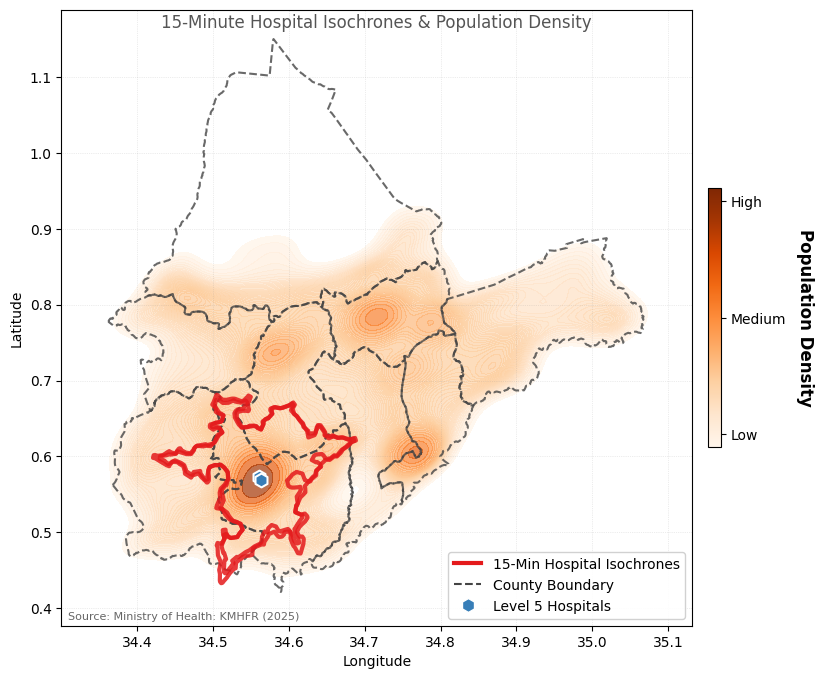

In [9]:

# Create plot with original figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Create custom colormap
orange_colors = ["#fff5eb","#fee6ce","#fdd0a2","#fdae6b","#fd8d3c",
                 "#f16913","#d94801","#a63603","#7f2704"]
custom_cmap = LinearSegmentedColormap.from_list("oranges", orange_colors)

# Step 1: Plot Population Density Heatmap (Background, Lowest Layer)
density = sns.kdeplot(
    x=df["longitude"],
    y=df["latitude"],
    weights=df["population"],
    cmap=custom_cmap,
    fill=True,
    alpha=0.7,
    levels=50,
    ax=ax,
    zorder=1  # LOWEST priority
)

# Step 2: Plot Bungoma boundary with nicer styling
boundary.plot(
    ax=ax,
    edgecolor='#444444',
    facecolor='none',
    linewidth=1.5,
    linestyle="--",
    zorder=2,
    alpha=0.8
)

# Step 3: Plot Isochrones with better styling
isochrones.plot(
    ax=ax,
    edgecolor='#e41a1c',
    facecolor='none',
    linewidth=3,
    alpha=0.85,
    zorder=4
)

# Step 4: Plot Hospitals with improved markers
hospital_points = ax.scatter(
    hospitals["longitude"],
    hospitals["latitude"],
    color="#377eb8",
    edgecolor="white",
    s=100,
    marker="h",  # Hospital symbol (square)
    linewidth=1.5,
    zorder=5,
    label="Hospitals"
)

# Add drop shadow effect to hospital markers for better visibility
hospital_shadow = ax.scatter(
    hospitals["longitude"],
    hospitals["latitude"],
    color="black",
    s=110,
    marker="h",
    alpha=0.3,
    zorder=4
)

# Colorbar for density
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap=custom_cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02, shrink=0.42)
cbar.set_label('Population Density', rotation=270, labelpad=20, fontsize=12, fontweight='bold')
cbar.set_ticks([0.05, 0.5, 0.95])
cbar.set_ticklabels(['Low', 'Medium', 'High'])
cbar.ax.tick_params(labelsize=10)

# Create manual legend with improved styling
legend_handles = [
    mlines.Line2D([], [], color='#e41a1c', linewidth=3, label="15-Min Hospital Isochrones"),
    mlines.Line2D([], [], color='#444444', linestyle="--", linewidth=1.5, label="County Boundary"),
    mlines.Line2D([], [], color='#377eb8', marker="h", linestyle="None",
                  markersize=10, markeredgecolor='white', label="Level 5 Hospitals"),
]

legend = ax.legend(
    handles=legend_handles,
    loc="lower right",
    frameon=True,
    framealpha=0.9,
    facecolor='white',
    edgecolor='#cccccc',
    fontsize=10
)


subtitle = ax.text(
    0.5, 0.97,
    "15-Minute Hospital Isochrones & Population Density",
    transform=ax.transAxes,
    ha='center',
    fontsize=12,
    color='#555555'
)

# Add subtle grid
ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.3, color='#888888')

# Improve axis labels
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)

# Add data source and notes
ax.text(
    0.01, 0.01,
    "Source: Ministry of Health: KMHFR (2025)",
    transform=ax.transAxes,
    fontsize=8,
    color='#666666',
    ha='left'
)

# Show plot
plt.show()

9.  Fixed Overlapping Isochrones by Merging & Clipping

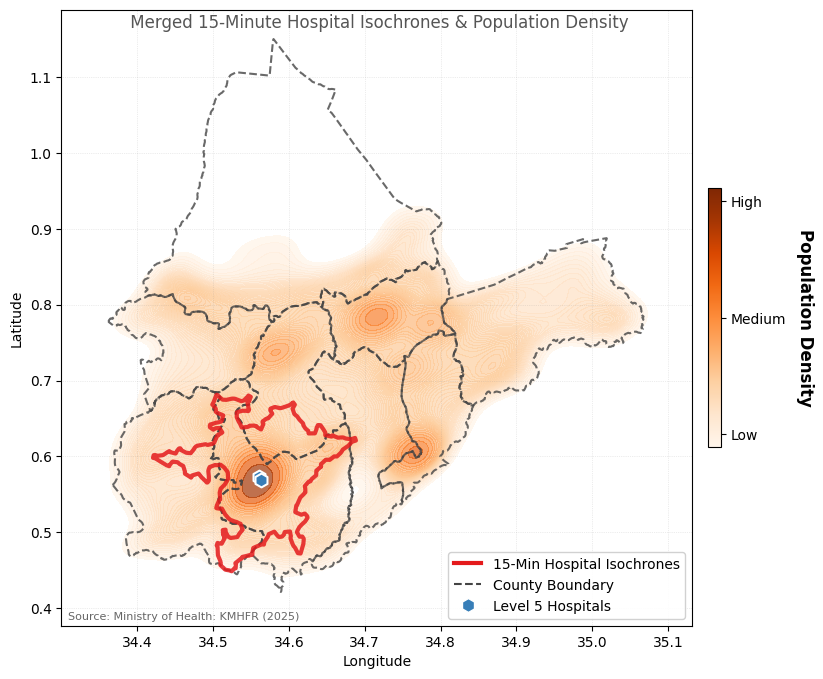

In [10]:
# Create plot with original figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Create custom colormap
orange_colors = ["#fff5eb","#fee6ce","#fdd0a2","#fdae6b","#fd8d3c",
                 "#f16913","#d94801","#a63603","#7f2704"]
custom_cmap = LinearSegmentedColormap.from_list("oranges", orange_colors)

# Step 1: Plot Population Density Heatmap (Background, Lowest Layer)
density = sns.kdeplot(
    x=df["longitude"],
    y=df["latitude"],
    weights=df["population"],
    cmap=custom_cmap,
    fill=True,
    alpha=0.7,
    levels=50,
    ax=ax,
    zorder=1  # LOWEST priority
)

# Step 2: Plot Bungoma boundary with nicer styling
boundary.plot(
    ax=ax,
    edgecolor='#444444',
    facecolor='none',
    linewidth=1.5,
    linestyle="--",
    zorder=2,
    alpha=0.8
)

# Step 3: Plot the unified and clipped isochrones with better styling
clipped_isochrones.plot(
    ax=ax,
    edgecolor='#e41a1c',
    facecolor='none',
    linewidth=3,
    alpha=0.85,
    zorder=4
)

# Step 4: Plot Hospitals with improved markers
hospital_points = ax.scatter(
    hospitals["longitude"],
    hospitals["latitude"],
    color="#377eb8",
    edgecolor="white",
    s=100,
    marker="h",  # Hospital symbol (square)
    linewidth=1.5,
    zorder=5,
    label="Hospitals"
)

# Add drop shadow effect to hospital markers for better visibility
hospital_shadow = ax.scatter(
    hospitals["longitude"],
    hospitals["latitude"],
    color="black",
    s=110,
    marker="h",
    alpha=0.3,
    zorder=4
)

# Colorbar for density
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap=custom_cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02, shrink=0.42)
cbar.set_label('Population Density', rotation=270, labelpad=20, fontsize=12, fontweight='bold')
cbar.set_ticks([0.05, 0.5, 0.95])
cbar.set_ticklabels(['Low', 'Medium', 'High'])
cbar.ax.tick_params(labelsize=10)

# Create manual legend with improved styling
legend_handles = [
    mlines.Line2D([], [], color='#e41a1c', linewidth=3, label="15-Min Hospital Isochrones"),
    mlines.Line2D([], [], color='#444444', linestyle="--", linewidth=1.5, label="County Boundary"),
    mlines.Line2D([], [], color='#377eb8', marker="h", linestyle="None",
                  markersize=10, markeredgecolor='white', label="Level 5 Hospitals"),
]

legend = ax.legend(
    handles=legend_handles,
    loc="lower right",
    frameon=True,
    framealpha=0.9,
    facecolor='white',
    edgecolor='#cccccc',
    fontsize=10
)

subtitle = ax.text(
    0.5, 0.97,
    " Merged 15-Minute Hospital Isochrones & Population Density",
    transform=ax.transAxes,
    ha='center',
    fontsize=12,
    color='#555555'
)

# Add subtle grid
ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.3, color='#888888')

# Improve axis labels
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)

# Add data source and notes
ax.text(
    0.01, 0.01,
    "Source: Ministry of Health: KMHFR (2025)",
    transform=ax.transAxes,
    fontsize=8,
    color='#666666',
    ha='left'
)

# Show plot
plt.show()

10. Calaculating Population (Total, Covered, and Uncovered)

In [11]:
covered_population = pop_covered["population"].sum()
coverage_percentage = (covered_population / total_population) * 100

print(f"Total Population in Bungoma: {total_population:,}")
print(f"Population Covered by 15-Min Isochrones: {covered_population:,}")
print(f"Coverage Percentage: {coverage_percentage:.2f}%")


Total Population in Bungoma: 1,805,036.6823217003
Population Covered by 15-Min Isochrones: 307,538.7345051
Coverage Percentage: 17.04%


11. Population points

Population points after filtering by boundary: 2453
Population points after removing clipped isochrones: 2215
Filtered population points saved to: /content/drive/MyDrive/healthcareBungoma/population_points.shp


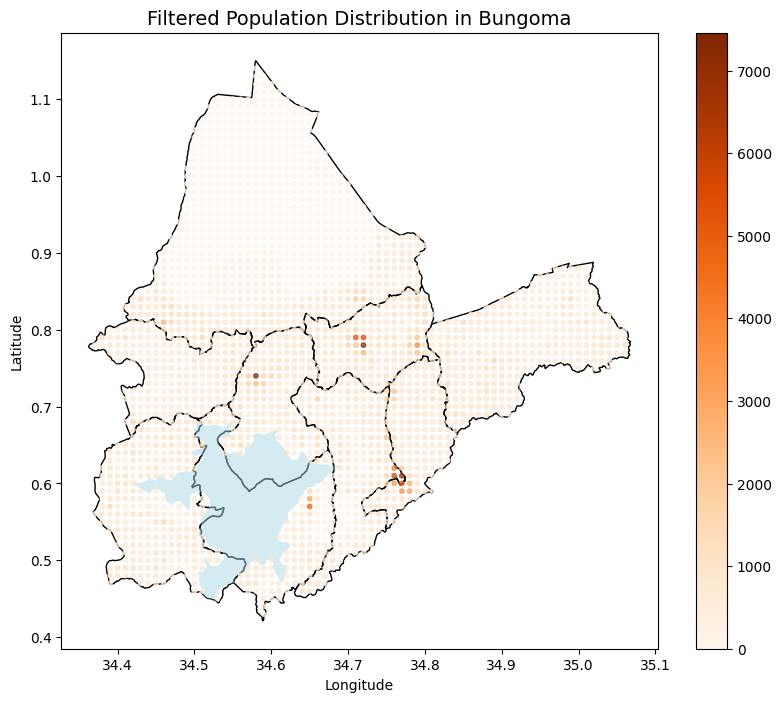

In [12]:
pop_df = pd.read_csv(csv_path)
pop_df["longitude"] = pop_df["longitude"].round(2)  # Round to ~1km grid
pop_df["latitude"] = pop_df["latitude"].round(2)
pop_aggregated = pop_df.groupby(["longitude", "latitude"]).aggregate({"population": "sum"}).reset_index()

# Convert to GeoDataFrame
pop_aggregated["geometry"] = [Point(x, y) for x, y in zip(pop_aggregated["longitude"], pop_aggregated["latitude"])]
population_gdf = gpd.GeoDataFrame(pop_aggregated, geometry="geometry", crs="EPSG:4326")

# Filter Points Inside Bungoma Boundary
population_gdf = population_gdf[population_gdf.within(boundary.geometry.union_all())]
print(f"Population points after filtering by boundary: {len(population_gdf)}")

# Remove Points Inside Clipped Isochrones
REMOVE_ISOCHRONES = True  # Change to False if you want to keep them
if REMOVE_ISOCHRONES:
    population_gdf = population_gdf[~population_gdf.intersects(isochrones_clipped.geometry.union_all())]
    print(f"Population points after removing clipped isochrones: {len(population_gdf)}")

#Save to Shapefile
output_shp = os.path.join(base_dir, "population_points.shp")
population_gdf.to_file(output_shp)
print(f"Filtered population points saved to: {output_shp}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Bungoma boundary
boundary.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Bungoma Boundary")

# Plot Clipped Isochrones
isochrones_clipped.plot(ax=ax, color="lightblue", alpha=0.5, label="Clipped 15-min Isochrones")

# Plot Population Points (Color-coded by Density)
population_gdf.plot(ax=ax, column="population", cmap="Oranges", markersize=10, alpha=0.7, legend=True)

# Customize Plot
ax.set_title("Filtered Population Distribution in Bungoma", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

12. Determinining Candidate Sites

Number of candidate sites: 2959


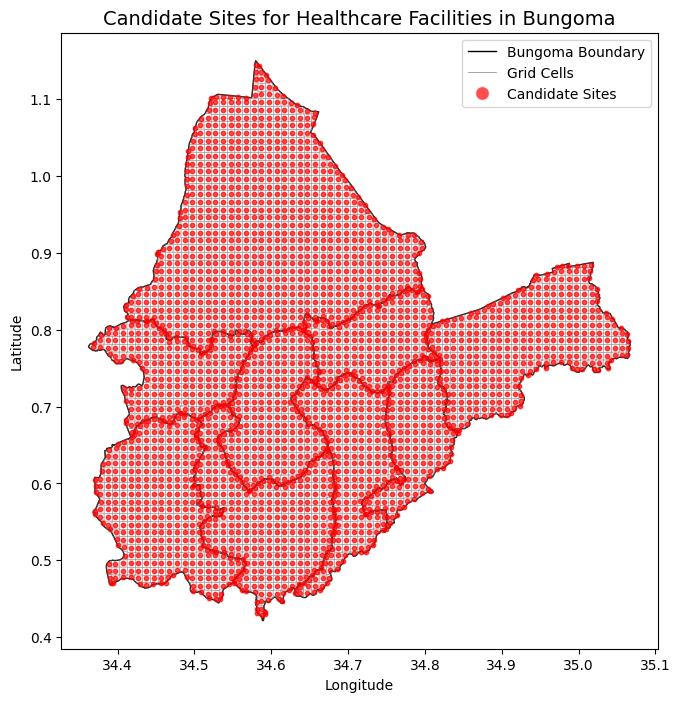

In [13]:
# Use grid centroids as candidate sites
# Convert to a projected CRS before calculating centroids
grid_proj = grid.to_crs("EPSG:32736")
grid_proj["centroid"] = grid_proj.centroid

# Convert the centroids back to the original geographic CRS for consistency with other layers
candidate_sites = gpd.GeoDataFrame(geometry=grid_proj["centroid"].to_crs("EPSG:4326"), crs="EPSG:4326")
print(f"Number of candidate sites: {len(candidate_sites)}")

#Visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the Bungoma boundary
boundary.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Bungoma Boundary")

# Plot the grid cells
# Store the plot output if needed, but remove the label argument for automatic legend
grid_plot_handle = grid.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.5, alpha=0.5)

# Plot candidate sites (grid centroids)
candidate_sites.plot(ax=ax, color="red", markersize=10, alpha=0.7, label="Candidate Sites")

# Customize the plot
ax.set_title("Candidate Sites for Healthcare Facilities in Bungoma", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Create manual legend handles to include the grid representation
legend_handles = [
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Bungoma Boundary'),
    Line2D([0], [0], color='gray', linewidth=0.5, linestyle='-', label='Grid Cells'), # Manual handle for grid
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, linestyle='None', label='Candidate Sites') # Manual handle for points
]

ax.legend(handles=legend_handles)


plt.show()

13. Filtering  to remain with only the best candidate sites

/tmp/ipython-input-3592489757.py:123: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



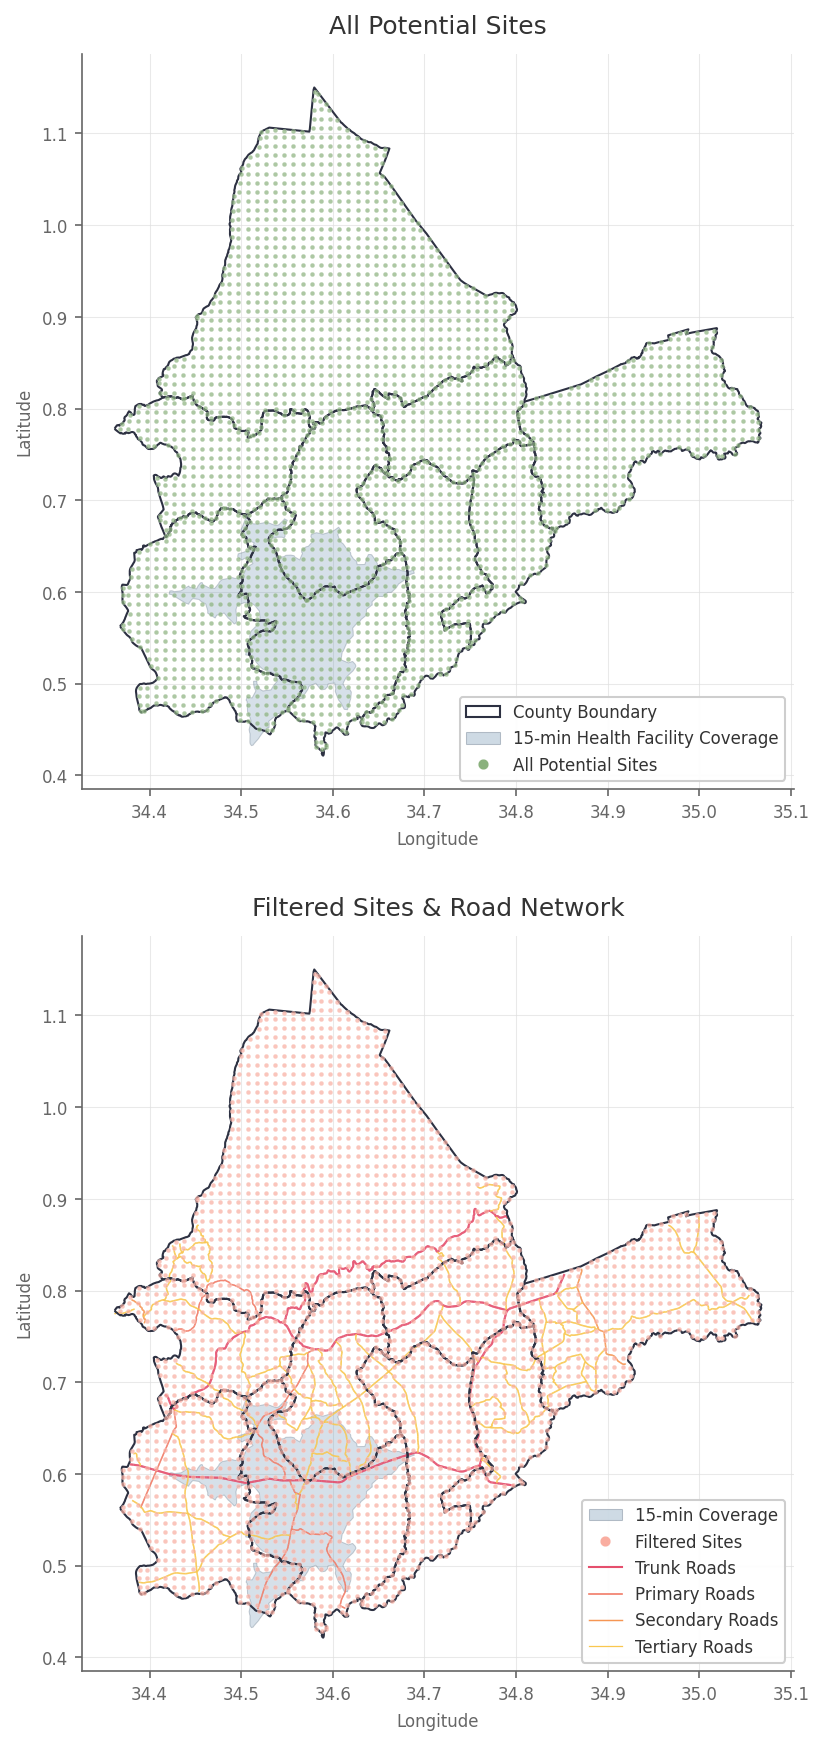

/tmp/ipython-input-3592489757.py:165: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



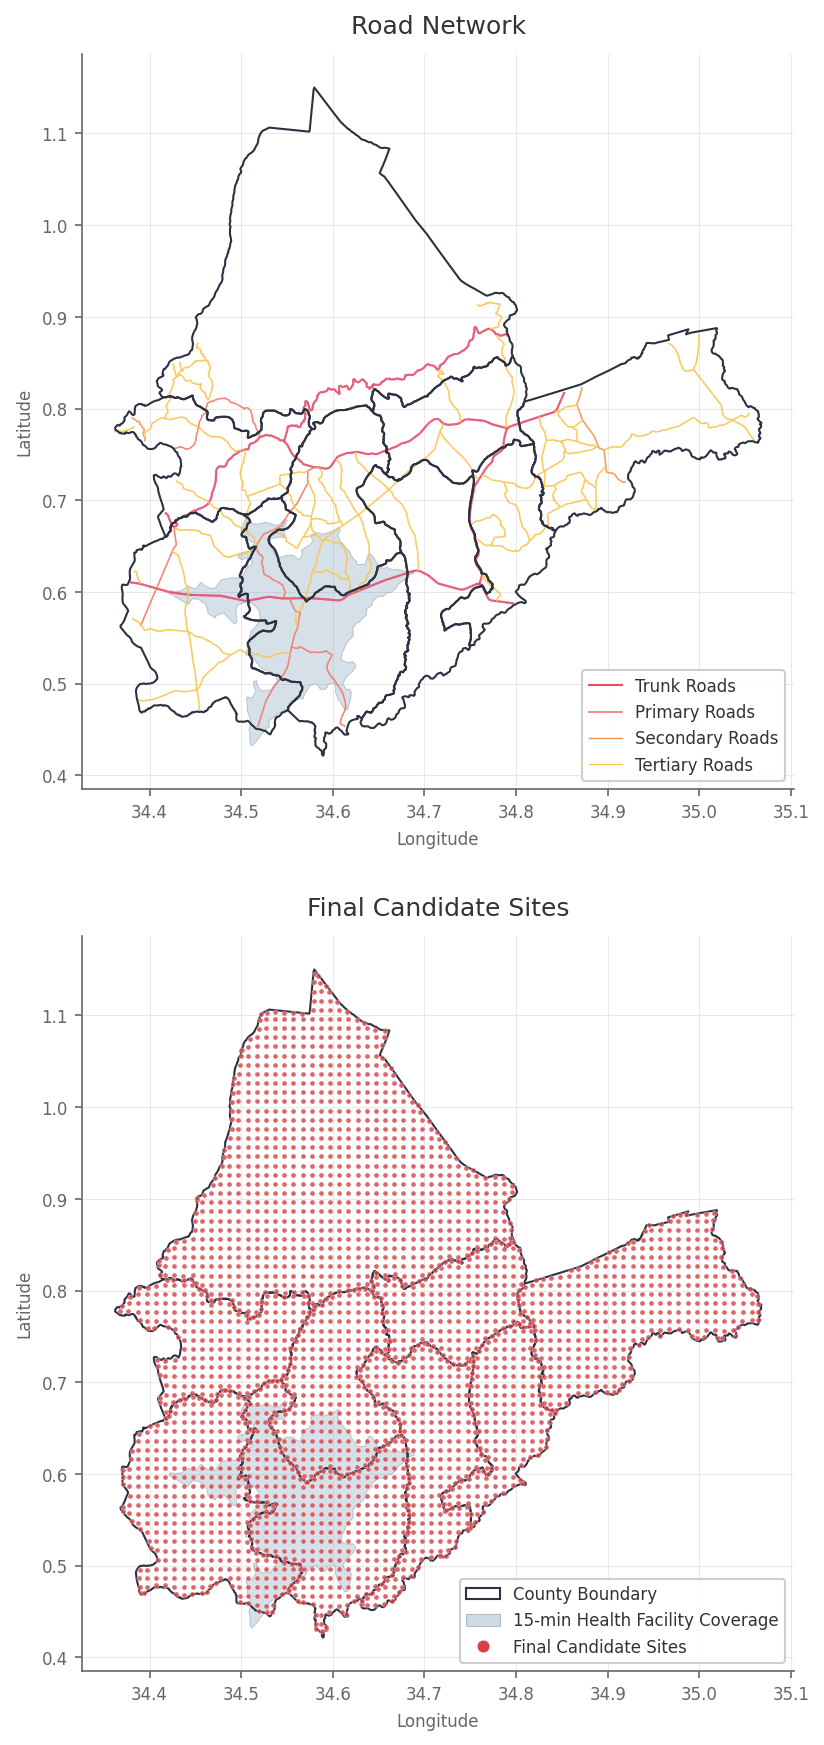

In [15]:
# ========== LEFT COLUMN VISUALIZATION ==========
# Set up a clean, professional style
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial', 'Helvetica', 'sans-serif'],
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 0.8,
    'figure.facecolor': 'white',
    'text.color': '#333333',
    'axes.edgecolor': '#666666',
    'axes.labelcolor': '#666666',
    'xtick.color': '#666666',
    'ytick.color': '#666666',
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

# Define a professional color palette
colors = {
    'boundary': '#2D3142',
    'isochrones': '#5D87A8',
    'isochrones_edge': '#334960',
    'all_sites': '#8AB17D',
    'filtered_sites': '#F9ADA0',
    'candidate_sites': '#D64045',
    'trunk_roads': '#E54F6D',
    'primary_roads': '#F17C67',
    'secondary_roads': '#F69653',
    'tertiary_roads': '#F9C74F',
    'text': '#333333',
    'subtitle': '#555555'
}

# Initialize all_sites with the full set of candidate sites from the previous step
all_sites = candidate_sites.copy()
# Initialize selected_roads with the roads data
selected_roads = roads.copy()

# Calculate the map bounds with a small buffer for aesthetics
xmin, ymin, xmax, ymax = boundary.total_bounds
buffer_x = (xmax - xmin) * 0.05
buffer_y = (ymax - ymin) * 0.05

# Function to set common map elements for all subplots
def setup_map_basics(ax, title):
    # Set map limits with buffer
    ax.set_xlim([xmin - buffer_x, xmax + buffer_x])
    ax.set_ylim([ymin - buffer_y, ymax + buffer_y])

    # Plot the isochrones with a nice semi-transparent fill (present in all plots)
    isochrones_merged.plot(ax=ax, color=colors['isochrones'], edgecolor=colors['isochrones_edge'],
                         linewidth=0.5, alpha=0.25, zorder=10)

    # Plot the county boundary with a clean, visible line
    boundary.boundary.plot(ax=ax, edgecolor=colors['boundary'], linewidth=1.0, zorder=30)

    # Add a title
    ax.set_title(title, fontsize=12, color=colors['text'], pad=10)

    # Fix axes - use decimal degrees with appropriate formatting
    ax.set_xlabel('Longitude', fontsize=8)
    ax.set_ylabel('Latitude', fontsize=8)

    # Make grid lines more subtle
    ax.grid(True, color='#e0e0e0', linestyle='-', linewidth=0.5, alpha=0.7)

# Function to plot roads
def plot_roads(ax):
    for road_type, color_key in [('trunk', 'trunk_roads'), ('primary', 'primary_roads'),
                               ('secondary', 'secondary_roads'), ('tertiary', 'tertiary_roads')]:
        road_subset = selected_roads[selected_roads["highway"].str.contains(road_type)]
        if not road_subset.empty:
            road_subset.plot(ax=ax, color=colors[color_key], linewidth=1.0 if road_type == 'trunk' else 0.7,
                            alpha=0.7, zorder=20)

# Create LEFT COLUMN figure with 2 vertical subplots
fig_left = plt.figure(figsize=(8, 14), dpi=150)
gs_left = GridSpec(2, 1, figure=fig_left, wspace=0.15, hspace=0.2)

# Create two subplots for left column
ax1 = fig_left.add_subplot(gs_left[0])  # Top: All sites
ax3 = fig_left.add_subplot(gs_left[1])  # Bottom: Filtered sites and roads

# ==== Plot 1: All Sites ====
setup_map_basics(ax1, "All Potential Sites")
all_sites.plot(ax=ax1, color=colors['all_sites'], marker='o', markersize=5,
             alpha=0.7, edgecolor='white', linewidth=0.1, zorder=40)

# Create legend for Plot 1
legend_elements1 = [
    mpatches.Patch(facecolor='none', edgecolor=colors['boundary'], linewidth=1.0, label='County Boundary'),
    mpatches.Patch(facecolor=colors['isochrones'], alpha=0.3, edgecolor=colors['isochrones_edge'],
                  linewidth=0.5, label='15-min Health Facility Coverage'),
    mlines.Line2D([], [], color=colors['all_sites'], marker='o', linestyle='None', markersize=5,
                markeredgecolor='white', markeredgewidth=0.1, label='All Potential Sites')
]
ax1.legend(handles=legend_elements1, loc='lower right', fontsize=8, frameon=True, framealpha=0.95)

# ==== Plot 3: Filtered Sites and Roads ====
setup_map_basics(ax3, "Filtered Sites & Road Network")
plot_roads(ax3)
candidate_sites.plot(ax=ax3, color=colors['filtered_sites'], marker='o', markersize=5,
                  alpha=0.7, edgecolor='white', linewidth=0.1, zorder=40)

# Create legend for Plot 3
legend_elements3 = [
    mpatches.Patch(facecolor=colors['isochrones'], alpha=0.3, edgecolor=colors['isochrones_edge'],
                  linewidth=0.5, label='15-min Coverage'),
    mlines.Line2D([], [], color=colors['filtered_sites'], marker='o', linestyle='None', markersize=5,
                markeredgecolor='white', markeredgewidth=0.1, label='Filtered Sites'),
    mlines.Line2D([], [], color=colors['trunk_roads'], linewidth=1.0, label='Trunk Roads'),
    mlines.Line2D([], [], color=colors['primary_roads'], linewidth=0.8, label='Primary Roads'),
    mlines.Line2D([], [], color=colors['secondary_roads'], linewidth=0.7, label='Secondary Roads'),
    mlines.Line2D([], [], color=colors['tertiary_roads'], linewidth=0.6, label='Tertiary Roads')
]
ax3.legend(handles=legend_elements3, loc='lower right', fontsize=8, frameon=True, framealpha=0.95)


# Save or show the left column figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ========== RIGHT COLUMN VISUALIZATION ==========

# Create RIGHT COLUMN figure with 2 vertical subplots
fig_right = plt.figure(figsize=(8, 14), dpi=150)
gs_right = GridSpec(2, 1, figure=fig_right, wspace=0.15, hspace=0.2)

# Create two subplots for right column
ax2 = fig_right.add_subplot(gs_right[0])  # Top: Roads only
ax4 = fig_right.add_subplot(gs_right[1])  # Bottom: Candidate sites

# ==== Plot 2: Roads Only ====
setup_map_basics(ax2, "Road Network")
plot_roads(ax2)

# Create legend for Plot 2
road_elements = [
    mlines.Line2D([], [], color=colors['trunk_roads'], linewidth=1.0, label='Trunk Roads'),
    mlines.Line2D([], [], color=colors['primary_roads'], linewidth=0.8, label='Primary Roads'),
    mlines.Line2D([], [], color=colors['secondary_roads'], linewidth=0.7, label='Secondary Roads'),
    mlines.Line2D([], [], color=colors['tertiary_roads'], linewidth=0.6, label='Tertiary Roads')
]
ax2.legend(handles=road_elements, loc='lower right', fontsize=8, frameon=True, framealpha=0.95)

# ==== Plot 4: Candidate Sites without Roads ====
setup_map_basics(ax4, "Final Candidate Sites")
candidate_sites.plot(ax=ax4, color=colors['candidate_sites'], marker='o', markersize=6,
                   alpha=0.8, edgecolor='white', linewidth=0.2, zorder=40)

# Create legend for Plot 4
legend_elements4 = [
    mpatches.Patch(facecolor='none', edgecolor=colors['boundary'], linewidth=1.0, label='County Boundary'),
    mpatches.Patch(facecolor=colors['isochrones'], alpha=0.3, edgecolor=colors['isochrones_edge'],
                  linewidth=0.5, label='15-min Health Facility Coverage'),
    mlines.Line2D([], [], color=colors['candidate_sites'], marker='o', linestyle='None', markersize=6,
                markeredgecolor='white', markeredgewidth=0.2, label='Final Candidate Sites')
]
ax4.legend(handles=legend_elements4, loc='lower right', fontsize=8, frameon=True, framealpha=0.95)

# Save or show the right column figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

14. MCLP Optimization

Optimization Status: Optimal

Selected Candidate Sites:
     FID                       geometry  cand_id
244  244  POINT (3849671.546 81632.188)      244
356  356  POINT (3864674.891 87667.266)      356
431  431   POINT (3870572.48 67522.726)      431

Total Weighted Covered Population: 35,673
Coverage Percentage: 2.41%
Could not load isochrones: /content/drive/MyDrive/healthcareBungoma/isochrones.shp: No such file or directory


/tmp/ipython-input-4025257364.py:218: UserWarning:

Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler



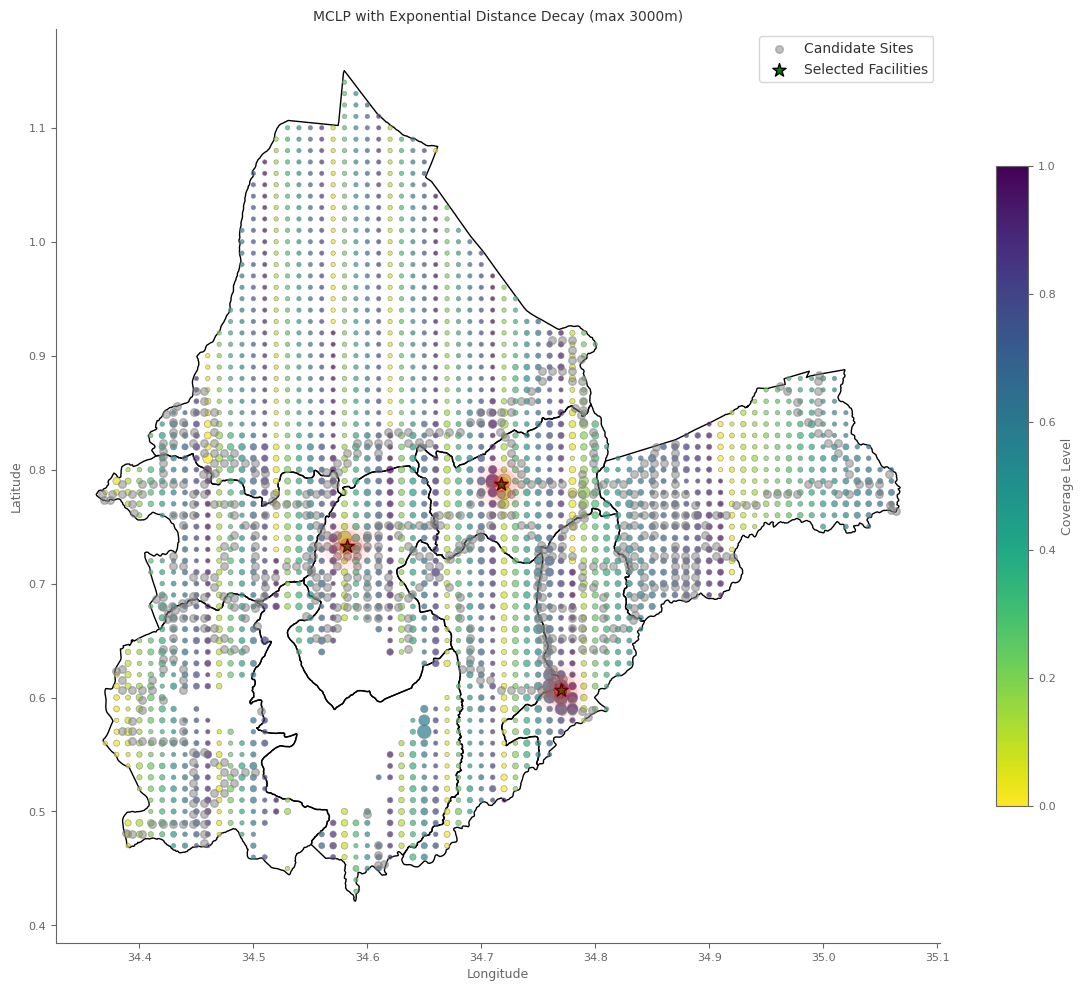

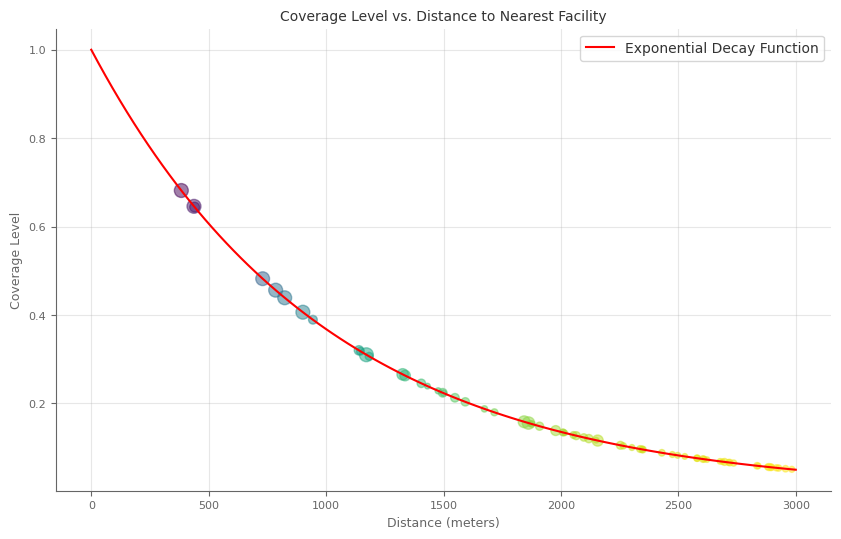

In [16]:
num_facilities = 3          # Number of facilities to locate
max_distance = 3000         # Maximum distance to consider (in meters)
decay_type = "exponential"       # Options: "linear", "exponential", "gaussian"

# -------------------------
# Load Data
# -------------------------
population_gdf = gpd.read_file(pop_points_shp)
candidate_sites = gpd.read_file(candidate_sites_shp)

# -------------------------
# Clean population data
# -------------------------
# Replace infinities and NaN values with 0
population_gdf['population'] = population_gdf['population'].replace([np.inf, -np.inf], np.nan).fillna(0)

# -------------------------
# Project to appropriate CRS - using Web Mercator (EPSG:3857) for distance calculations
# -------------------------
population_proj = population_gdf.to_crs("EPSG:3857")
candidates_proj = candidate_sites.to_crs("EPSG:3857")

# Reset index and assign unique candidate IDs
candidates_proj = candidates_proj.reset_index(drop=True)
candidates_proj['cand_id'] = candidates_proj.index

# -------------------------
# Distance decay functions
# -------------------------
def linear_decay(distance, max_dist):
    """Linear distance decay: coverage declines proportionally with distance"""
    if distance > max_dist:
        return 0
    return 1 - (distance / max_dist)

def exponential_decay(distance, max_dist):
    """Exponential distance decay: coverage declines more rapidly at first"""
    if distance > max_dist:
        return 0
    # Scale factor controls how quickly the decay happens
    scale_factor = 3
    return np.exp(-scale_factor * distance / max_dist)

def gaussian_decay(distance, max_dist):
    """Gaussian distance decay: coverage remains high near the facility but drops off rapidly"""
    if distance > max_dist:
        return 0
    # Standard deviation controls how quickly the decay happens
    std_dev = max_dist / 3
    return np.exp(-(distance**2) / (2 * std_dev**2))

# Select the decay function based on the parameter
if decay_type == "linear":
    decay_function = linear_decay
elif decay_type == "exponential":
    decay_function = exponential_decay
elif decay_type == "gaussian":
    decay_function = gaussian_decay
else:
    raise ValueError(f"Unknown decay type: {decay_type}")

# -------------------------
# Build the Coverage Dictionary with Distance Decay
# -------------------------
coverage = {}  # Key: population point index, value: dict of candidate indices and their weights
distances = {}  # Store all distances for later visualization

for i, pop_point in population_proj.iterrows():
    coverage[i] = {}
    for j, cand in candidates_proj.iterrows():
        distance = pop_point.geometry.distance(cand.geometry)
        distances[(i, j)] = distance

        # Apply distance decay function
        if distance <= max_distance:
            coverage_weight = decay_function(distance, max_distance)
            if coverage_weight > 0:
                coverage[i][j] = coverage_weight

# Create a dictionary for population values
pop_values = population_proj["population"].to_dict()

# -------------------------
# Define the MCLP Model in PuLP with Distance Decay
# -------------------------
model = pulp.LpProblem("MCLP_Distance_Decay", pulp.LpMaximize)

# Decision variables:
# y_j = 1 if candidate site j is selected; 0 otherwise.
y = pulp.LpVariable.dicts("y", candidates_proj.index, 0, 1, cat="Binary")

# Define a continuous variable for each population point representing its coverage level (0-1)
coverage_level = pulp.LpVariable.dicts("coverage", population_proj.index, 0, 1, cat="Continuous")

# Objective: maximize the weighted covered population
model += pulp.lpSum([pop_values[i] * coverage_level[i] for i in population_proj.index]), "Total_Weighted_Covered_Population"

# Constraint: Limit the number of facilities
model += pulp.lpSum([y[j] for j in candidates_proj.index]) <= num_facilities, "Facility_Limit"

# Coverage constraints: The coverage level for each population point is the maximum
# of the coverage weights of the selected facilities
for i in population_proj.index:
    if not coverage[i]:  # If no facilities can cover this point
        model += coverage_level[i] == 0, f"No_Coverage_{i}"
    else:
        # For each potential facility that can cover point i
        for j in coverage[i]:
            # The coverage level can't exceed the weighted coverage from this facility if selected
            model += coverage_level[i] <= coverage[i][j] * y[j] + \
                     (1 - y[j]), f"Coverage_From_{i}_{j}"

        # Ensure the coverage level doesn't exceed the sum of all weighted coverages
        # This is a redundant constraint but may help the solver
        model += coverage_level[i] <= pulp.lpSum([coverage[i][j] * y[j] for j in coverage[i]]), f"Total_Coverage_{i}"

# -------------------------
# Solve the Model using CBC solver with explicit options
# -------------------------
solver = pulp.PULP_CBC_CMD(msg=True, timeLimit=300)  # 300-second time limit
model.solve(solver)
print("Optimization Status:", pulp.LpStatus[model.status])

# -------------------------
# Retrieve Results
# -------------------------
selected_candidates_idx = [j for j in candidates_proj.index if pulp.value(y[j]) > 0.5]
selected_candidates = candidates_proj.loc[selected_candidates_idx]
print("\nSelected Candidate Sites:")
print(selected_candidates)

# Calculate the coverage level for each population point
coverage_results = {i: pulp.value(coverage_level[i]) for i in population_proj.index}

# Add coverage values to the population GeoDataFrame for visualization
population_proj['coverage'] = population_proj.index.map(lambda i: coverage_results.get(i, 0))

# Calculate total weighted covered population
total_weighted_pop = sum(pop_values[i] * coverage_results[i] for i in population_proj.index)
print(f"\nTotal Weighted Covered Population: {total_weighted_pop:,.0f}")

# Calculate percentage of total population covered
total_population = sum(pop_values.values())
coverage_percentage = (total_weighted_pop / total_population) * 100 if total_population > 0 else 0
print(f"Coverage Percentage: {coverage_percentage:.2f}%")

# -------------------------
# Visualization
# -------------------------

# Load boundary data for context
boundary_shp = "/content/drive/My Drive/healthcareBungoma/data/bungoma_boundary.shp"
boundary = gpd.read_file(boundary_shp).to_crs("EPSG:4326")

# Convert projected data back to WGS84 for mapping
population_viz = population_proj.to_crs("EPSG:4326")
selected_candidates_viz = selected_candidates.to_crs("EPSG:4326")

# Create the base plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Bungoma boundary
boundary.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Bungoma Boundary")

# Create a colormap for coverage levels
norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = plt.cm.viridis_r
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot population points colored by coverage level
population_viz.plot(ax=ax,
                    c=population_viz['coverage'],
                    cmap=cmap,
                    markersize=population_viz['population'].apply(lambda x: max(10, min(100, x/50))),
                    alpha=0.7,
                    edgecolor='grey',
                    linewidth=0.5)

# Add a colorbar
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Coverage Level')

# Plot all candidate sites in gray
candidates_proj.to_crs("EPSG:4326").plot(ax=ax, color="grey", marker="o", markersize=30, alpha=0.5, label="Candidate Sites")

# Plot selected candidate sites in green with a star marker
selected_candidates_viz.plot(ax=ax, marker="*", color="green", markersize=100, edgecolor="black", linewidth=1, label="Selected Facilities")

# Plot isochrones if available
try:
    isochrones_shp = os.path.join(base_dir, "isochrones.shp")
    isochrones = gpd.read_file(isochrones_shp).to_crs("EPSG:4326")
    isochrones_merged = isochrones.dissolve()
    isochrones_clipped = gpd.clip(isochrones_merged, boundary)
    isochrones_clipped.plot(ax=ax, color="lightgreen", alpha=0.3, label="15-min Isochrones")
except Exception as e:
    print(f"Could not load isochrones: {e}")

# Add distance decay contours around selected facilities
for idx in selected_candidates_idx:
    facility = candidates_proj.loc[idx].geometry

    # Create contour rings at different distance thresholds
    contour_distances = [max_distance * ratio for ratio in [0.25, 0.5, 0.75, 1.0]]
    for dist in contour_distances:
        # Create a buffer at this distance
        buffer = gpd.GeoDataFrame(geometry=[facility.buffer(dist)], crs="EPSG:3857")
        # Convert to WGS84 for plotting
        buffer = buffer.to_crs("EPSG:4326")
        # Plot with decreasing opacity for further distances
        opacity = decay_function(dist, max_distance) * 0.5
        buffer.plot(ax=ax, color="red", alpha=opacity, edgecolor="red", linewidth=0.5)

ax.set_title(f"MCLP with {decay_type.capitalize()} Distance Decay (max {max_distance}m)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

# -------------------------
# Additional Analysis
# -------------------------
# Examine the distribution of coverage levels
coverage_levels = list(coverage_results.values())

# Calculate coverage statistics by distance
coverage_by_distance = []
for i in population_proj.index:
    if coverage_results[i] > 0:
        # Find minimum distance to any selected facility
        min_distance = min(distances.get((i, j), float('inf')) for j in selected_candidates_idx)
        coverage_by_distance.append((min_distance, coverage_results[i], pop_values[i]))

if coverage_by_distance:
    distance_df = pd.DataFrame(coverage_by_distance, columns=['distance', 'coverage', 'population'])

    plt.figure(figsize=(10, 6))
    plt.scatter(distance_df['distance'], distance_df['coverage'],
                s=distance_df['population'].apply(lambda x: max(10, min(100, x/50))),
                alpha=0.5, c=distance_df['coverage'], cmap='viridis_r')

    # Add the theoretical decay function curve
    distances_range = np.linspace(0, max_distance, 100)
    decay_values = [decay_function(d, max_distance) for d in distances_range]
    plt.plot(distances_range, decay_values, 'r-', label=f'{decay_type.capitalize()} Decay Function')

    plt.title('Coverage Level vs. Distance to Nearest Facility')
    plt.xlabel('Distance (meters)')
    plt.ylabel('Coverage Level')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

Optimized Sites and Final Map

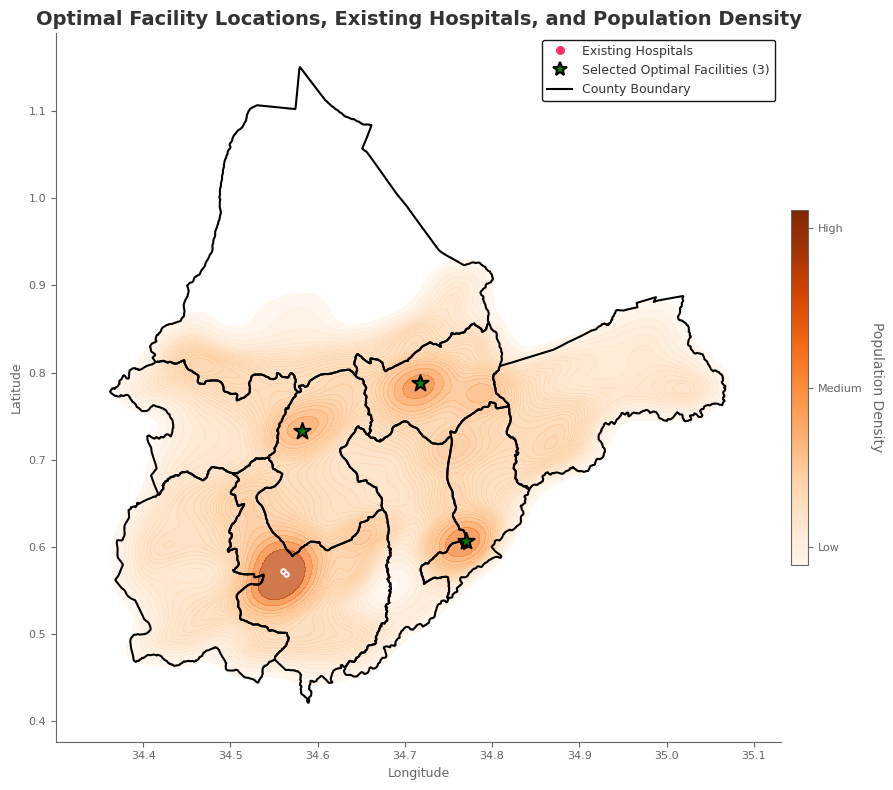

In [17]:
import matplotlib.colors as mcolors

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create custom orange colormap (using the one already defined)
orange_colors = ["#fff5eb","#fee6ce","#fdd0a2","#fdae6b","#fd8d3c",
                 "#f16913","#d94801","#a63603","#7f2704"]
custom_cmap = LinearSegmentedColormap.from_list("oranges", orange_colors)

# Plot boundary
boundary.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5, zorder=3)

# Population density KDE (using the custom_cmap)
sns.kdeplot(
    x=df.longitude, y=df.latitude,
    weights=df.population,
    cmap=custom_cmap, fill=True,
    alpha=0.7, levels=30, thresh=0.05,
    ax=ax, zorder=2
)

# Add basemap (optional, can be removed if just boundary and points are needed)
# ctx.add_basemap(
#     ax, crs=boundary.crs,
#     source=ctx.providers.OpenStreetMap.Mapnik,
#     alpha=0.6, zorder=1
# )

# Plot existing hospitals
ax.scatter(
    gdf_hospitals.geometry.x,
    gdf_hospitals.geometry.y,
    color='#FF3366',  # A distinct color for existing hospitals
    s=10,
    marker="o",  # Use a different marker for existing hospitals
    edgecolor='white',
    linewidth=1.5,
    zorder=5,
    label='Existing Hospitals' # Add label for legend
)

# Plot selected optimal locations
selected_candidates_viz.plot(
    ax=ax,
    marker="*",
    color="green", # Color for selected facilities
    markersize=150, # Larger size to make them prominent
    edgecolor="black",
    linewidth=1.5,
    zorder=6, # Higher zorder to be on top
    label=f'Selected Optimal Facilities ({num_facilities})' # Add label for legend
)


# Titles & axes
ax.set_title(
    "Optimal Facility Locations, Existing Hospitals, and Population Density",
    fontsize=14, fontweight='bold'
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Colorbar for density (using the custom_cmap)
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap=custom_cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01, shrink=0.5)
cbar.set_label('Population Density', rotation=270, labelpad=15, fontsize=10)
# Adjust ticks based on KDE output, or keep simple low/medium/high
cbar.set_ticks([0.05, 0.5, 0.95]) # Example ticks
cbar.set_ticklabels(['Low', 'Medium', 'High']) # Example labels


# Create Legend
# Manually create legend handles for clarity
legend_handles = [
    mlines.Line2D([], [], color='none', marker='o', markerfacecolor='#FF3366', markersize=8, markeredgecolor='white', markeredgewidth=1.5, linestyle='None', label='Existing Hospitals'),
    mlines.Line2D([], [], color='none', marker='*', markerfacecolor='green', markersize=10, markeredgecolor='black', markeredgewidth=1.5, linestyle='None', label=f'Selected Optimal Facilities ({num_facilities})'),
    mlines.Line2D([], [], color='black', linewidth=1.5, linestyle='-', label='County Boundary')
]

ax.legend(handles=legend_handles, loc='upper right', frameon=True, framealpha=0.9, edgecolor='black', fontsize=9)


plt.tight_layout()
plt.show()